In [1]:
!pip install matplotlib

# 라이브러리 확인

In [1]:
import dlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

C:\Users\hi\anaconda3\envs\p36_beautygan\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hi\anaconda3\envs\p36_beautygan\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hi\anaconda3\envs\p36_beautygan\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hi\anaconda3\envs\p36_beautygan\lib\site-packages

# 학습된 모델 불러오기

In [2]:
detector = dlib.get_frontal_face_detector()
# sp = dlib.shape_predictor("./trained/shape_predictor_68_face_landmarks.dat")
sp = dlib.shape_predictor("./trained/shape_predictor_5_face_landmarks.dat")

In [3]:
# Pre-Trained 모델 불러오기
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph('./model/model.meta')
saver.restore(sess, tf.train.latest_checkpoint('./model'))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ./model\model


In [4]:
!pip install tensorflow==1.9

  Using cached setuptools-39.1.0-py2.py3-none-any.whl (566 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.6.0
    Uninstalling setuptools-59.6.0:
      Successfully uninstalled setuptools-59.6.0


In [5]:
# BeautyGAN X, Y, Xs 설정
X = graph.get_tensor_by_name('X:0') # source
Y = graph.get_tensor_by_name('Y:0') # reference
Xs = graph.get_tensor_by_name('generator/xs:0') # 화장한 결과값

In [6]:
# 전처리 (실수: `1 ~ 1)
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.

# 복원(0 ~ 255)
def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)

# 얼굴 분리

In [7]:
# 이미지를 넣으면 수평에 맞게 이미지 추출
def face_align(img):
    dets = detector(img, 1)
    
    objs = dlib.full_object_detections()
    
    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
        
    # 얼굴 추출
    faces = dlib.get_face_chips(img, objs, size = 256, padding = 0.35)
    
    return faces

# 얼굴 불러오기

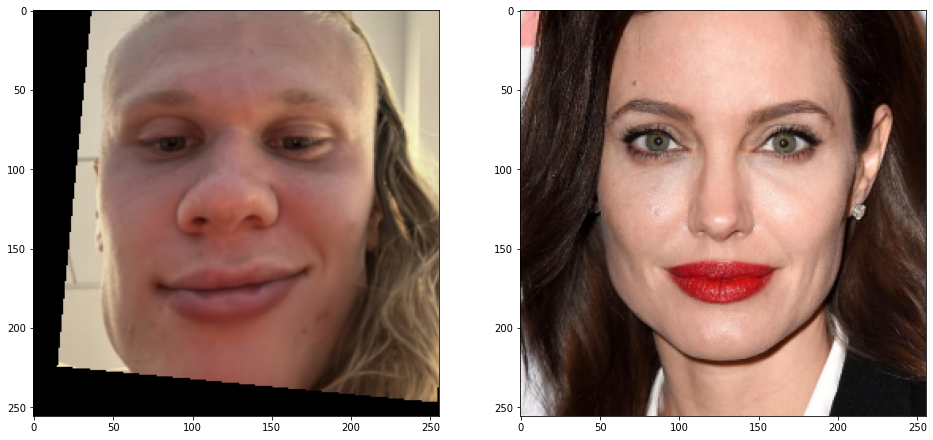

In [27]:
# 원본 이미지
org_img = dlib.load_rgb_image('./source/haaland1.jpg')

# 화장할 이미지
ref_img = dlib.load_rgb_image('./ref/jol.jpg')

# 얼굴 추출
org_face = face_align(org_img)
ref_face = face_align(ref_img)

# 얼굴 확인
fig, axes = plt.subplots(1, 2, figsize = (16, 10))
axes[0].imshow(org_face[0])
axes[1].imshow(ref_face[0])

# BeautyGAN 가동하기

In [28]:
src_img = org_face[0]
ref_img = ref_face[0]

# 전처리
X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0)#  (1, x, y, 3) # 1개만 넣을 때 옵션에 차원 1개를(1)을 넣어줘야 한다.

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img, axis=0)

# GAN 동작
output = sess.run(Xs, feed_dict={X : X_img, Y : Y_img})

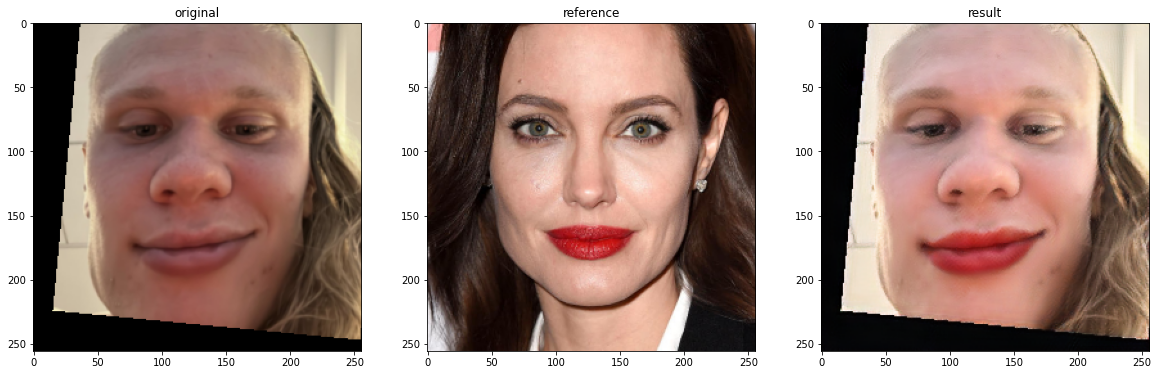

In [29]:
# 결과 확인
# 복원
result_img = postprocess(output[0])
fix, axes = plt.subplots(1, 3, figsize = (20, 10))
axes[0].set_title('original')
axes[0].imshow(src_img)
axes[1].set_title('reference')
axes[1].imshow(ref_img)
axes[2].set_title('result')
axes[2].imshow(result_img)